In [9]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import argparse
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import pyvista as pv
import numpy as np

from cls.data import ModelNet40
from PointMixup.emd_ import emd_module
from PointMixup.cd.chamferdist import ChamferDistance as CD


parser = argparse.ArgumentParser(description='Point Cloud Recognition')
parser.add_argument('--num_points', type=int, default=1024,
                    help='num of points to use')
parser.add_argument('--batch_size', type=int, default=16,
                    help='num of points to use')
parser.add_argument('--sigma', type=float, default=1,
                    help='num of points to use')
args = parser.parse_args([])

args.num_class = 40

train_loader = DataLoader(ModelNet40(partition='train', num_points=args.num_points), num_workers=8,
                                batch_size=args.batch_size, shuffle=True, drop_last=True)
device = torch.device("cuda")

EMD = emd_module.emdModule()
cd = CD()

w=torch.zeros(0).cuda()
beta = torch.distributions.beta.Beta(torch.tensor([0.4]), torch.tensor([0.4]))

for data, label in train_loader:
    data, label =data.to(device), label.to(device)
    batch_size = data.size()[0]
    
    label_onehot = torch.zeros(batch_size, 40).cuda().scatter(1, label.view(-1, 1), 1)
    
    idxs = torch.randperm(batch_size)
    perm = data[idxs]
    label_perm_onehot = label_onehot[idxs]

#     data = data - data.mean(1, keepdim=True)
#     data = data / data.norm(dim=2,keepdim=True).max(1, keepdim=True)[0]
    
#     perm = perm - perm.mean(1, keepdim=True)
#     perm = perm / perm.norm(dim=2,keepdim=True).max(1, keepdim=True)[0]
    

    alpha = beta.sample((batch_size,)).to(data.device)
#     alpha = 0.5
    
    origin_data = data
    origin_perm = perm

    _, ass = EMD(data, perm, 0.005, 500) # mapping
    ass = ass.long()
    perm = perm[:,ass][torch.arange(batch_size),torch.arange(batch_size)]

    anc_idx = torch.randperm(args.num_points)[:2]
    anchor_ori, anchor_perm = data[:,anc_idx[0],:], perm[:,anc_idx[1], :]

    sub_ori = data - anchor_ori[:,None,:]
    sub_ori = ((sub_ori) ** 2).sum(2).sqrt()
    weight_ori = torch.exp(-0.5 * (sub_ori ** 2) / (args.sigma ** 2))  #(M,N)
    weight_ori = weight_ori * alpha

    sub_perm = perm - anchor_perm[:,None,:]
    sub_perm = ((sub_perm) ** 2).sum(2).sqrt()   
    weight_perm = torch.exp(-0.5 * (sub_perm ** 2) / (args.sigma ** 2))  #(M,N)
    weight_perm = weight_perm * (1-alpha)

    weight = (torch.cat([weight_ori[...,None],weight_perm[...,None]],-1))+1e-16
    weight = weight/weight.sum(-1)[...,None]
    data = weight[:,:,0:1] * data + weight[:,:,1:] * perm

    target = weight.sum(1)
    target = target / target.sum(-1, keepdim=True)
    label = target[:, 0, None] * label_onehot + target[:, 1, None] * label_perm_onehot
    
#     break
    w_ = weight.sum(1)
    w_ = w_/w_.sum(dim=1, keepdim=True)
    w = torch.cat([w, w_.flatten()])
    

x1


/home/sanghyeok/.conda/envs/NIPS/lib/python3.9/site-packages/pyvista/jupyter/notebook.py:60: UserWarning: Failed to use notebook backend: 

Please install `ipyvtklink` to use this feature: https://github.com/Kitware/ipyvtklink

Falling back to a static output.
  warnings.warn(f'Failed to use notebook backend: \n\n{e}\n\n'


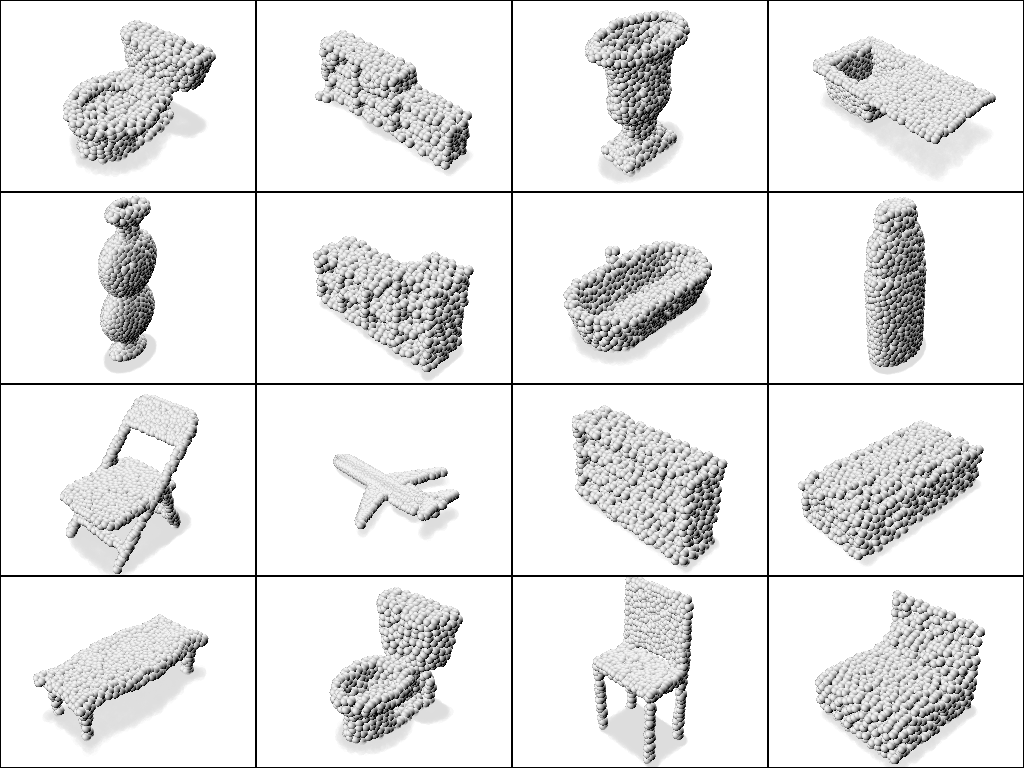

x2


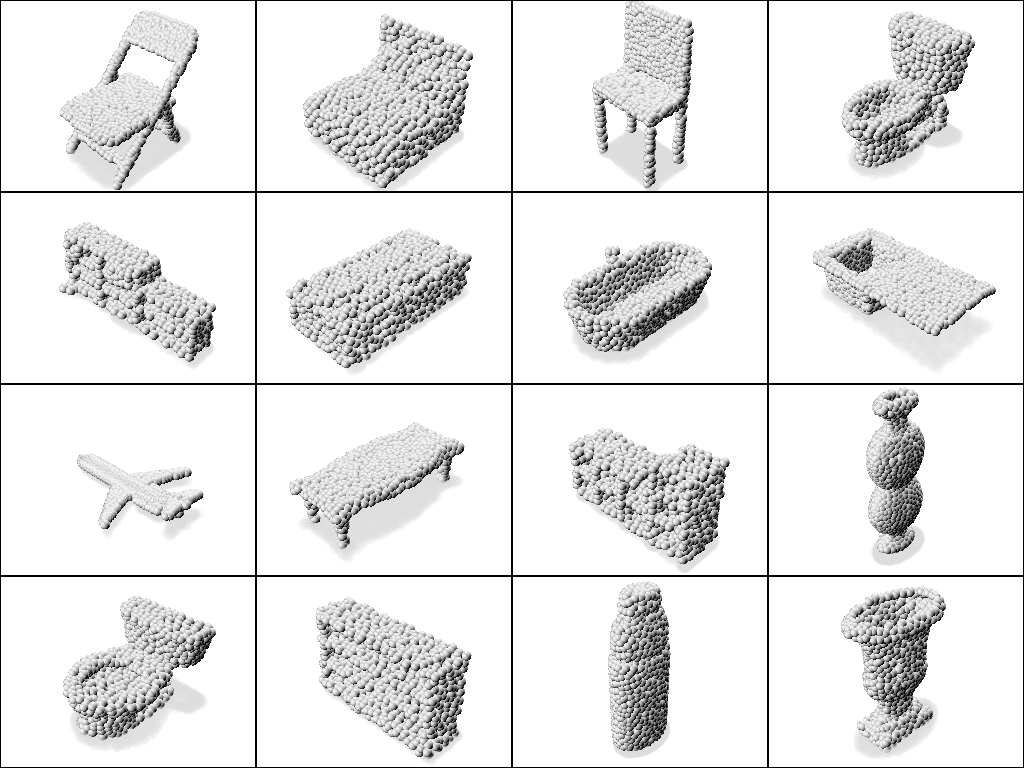

mixup


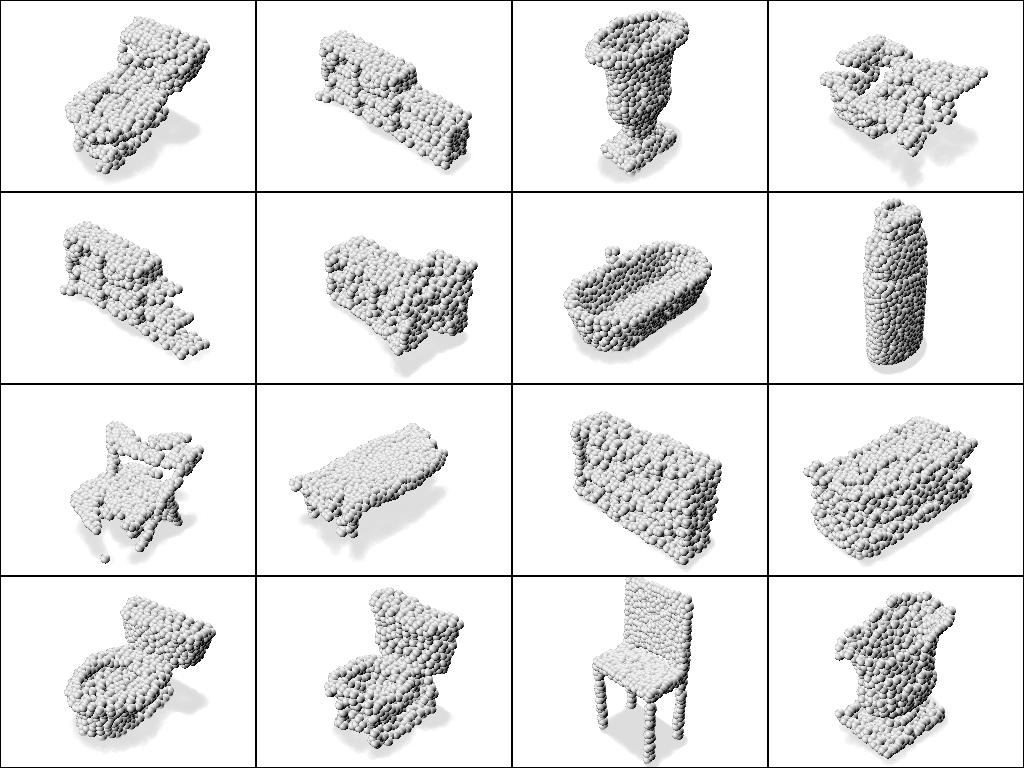

In [10]:
def get_shadow(plotter, pos, point_size,scale=3, origin=None, opacitiy=0.1, color= "#dddddd"):
    #pos (n,3)
    pos  =pos.repeat(scale, 0) 
    pos +=  np.random.rand(pos.shape[0],pos.shape[1])/20

    point_cloud = pv.PolyData(pos)

    if origin is None:
        origin = [0,0,pos[:,2].min() - 0.05]
    point_cloud = point_cloud.project_points_to_plane(origin=origin, normal=[0,0,-1])

    plotter.add_points(point_cloud, point_size=point_size, render_points_as_spheres=True,\
                        opacity=opacitiy, color = color, lighting=False) 

import seaborn as sns
pv.start_xvfb()
camera_pos = [1,-1,1]#,[0,0,1]]

subplot_point_size = 10
g_subplot_point_size= 15

cmap = sns.color_palette("light:salmon", 5).as_hex()
scale = 1.1
cmap = ["#{:02x}{:02x}{:02x}".format(min(255, int(int(x[1:3],16)*scale)),
                                        min(255, int(int(x[3:5],16)*scale)),
                                        min(255, int(int(x[5:],16)*scale))) for x in cmap.as_hex()]



plotter = pv.Plotter(notebook=True,shape=(4,4), lighting="none")

print("x1")
for i in range(16):
    plotter.subplot(i//4, i%4)
    plotter.background_color = "W"
    point_cloud = pv.PolyData(origin_data[i][:,[0,2,1]].cpu().numpy())
    point_cloud['y'] = torch.zeros(args.num_points).numpy()
    plotter.add_points(point_cloud, point_size=subplot_point_size, render_points_as_spheres=True, cmap=cmap)
    plotter.camera_position = camera_pos
    
    get_shadow(plotter, origin_data[i].cpu().numpy()[:,[0,2,1]], subplot_point_size)
    
    if i<8:
        light = pv.Light(intensity=0.12)
        light.set_direction_angle(30,90)
        plotter.add_light(light)
        light = pv.Light(intensity=0.12)
        light.set_direction_angle(30,-90)
        plotter.add_light(light)

#     plotter.enable_shadows()
    plotter.remove_scalar_bar()

plotter.show()

print("x2")
plotter = pv.Plotter(notebook=True,shape=(4,4), lighting="none")

for i in range(16):
    plotter.subplot(i//4, i%4)
    plotter.background_color = "W"
    point_cloud = pv.PolyData(origin_perm[i][:,[0,2,1]].cpu().numpy())
    point_cloud['y'] = torch.zeros(args.num_points).numpy()
    plotter.add_points(point_cloud, point_size=subplot_point_size, render_points_as_spheres=True, cmap=cmap)
    plotter.camera_position = camera_pos
    
    get_shadow(plotter, origin_perm[i].cpu().numpy()[:,[0,2,1]], subplot_point_size)
    
    if i<8:
        light = pv.Light(intensity=0.12)
        light.set_direction_angle(30,90)
        plotter.add_light(light)
        light = pv.Light(intensity=0.12)
        light.set_direction_angle(30,-90)
        plotter.add_light(light)

#     plotter.enable_shadows()
    plotter.remove_scalar_bar()

plotter.show()

plotter = pv.Plotter(notebook=True,shape=(4,4), lighting="none")

print("mixup")
plotter = pv.Plotter(notebook=True,shape=(4,4), lighting="none")

for i in range(16):
    plotter.subplot(i//4, i%4)
    plotter.background_color = "W"
    point_cloud = pv.PolyData(data[i][:,[0,2,1]].cpu().numpy())
    point_cloud['y'] = torch.zeros(args.num_points).numpy()
    plotter.add_points(point_cloud, point_size=subplot_point_size, render_points_as_spheres=True, cmap=cmap)
    plotter.camera_position = camera_pos
    
    get_shadow(plotter, data[i].cpu().numpy()[:,[0,2,1]], subplot_point_size)
    
    if i<8:
        light = pv.Light(intensity=0.12)
        light.set_direction_angle(30,90)
        plotter.add_light(light)
        light = pv.Light(intensity=0.12)
        light.set_direction_angle(30,-90)
        plotter.add_light(light)

#     plotter.enable_shadows()
    plotter.remove_scalar_bar()

plotter.show()




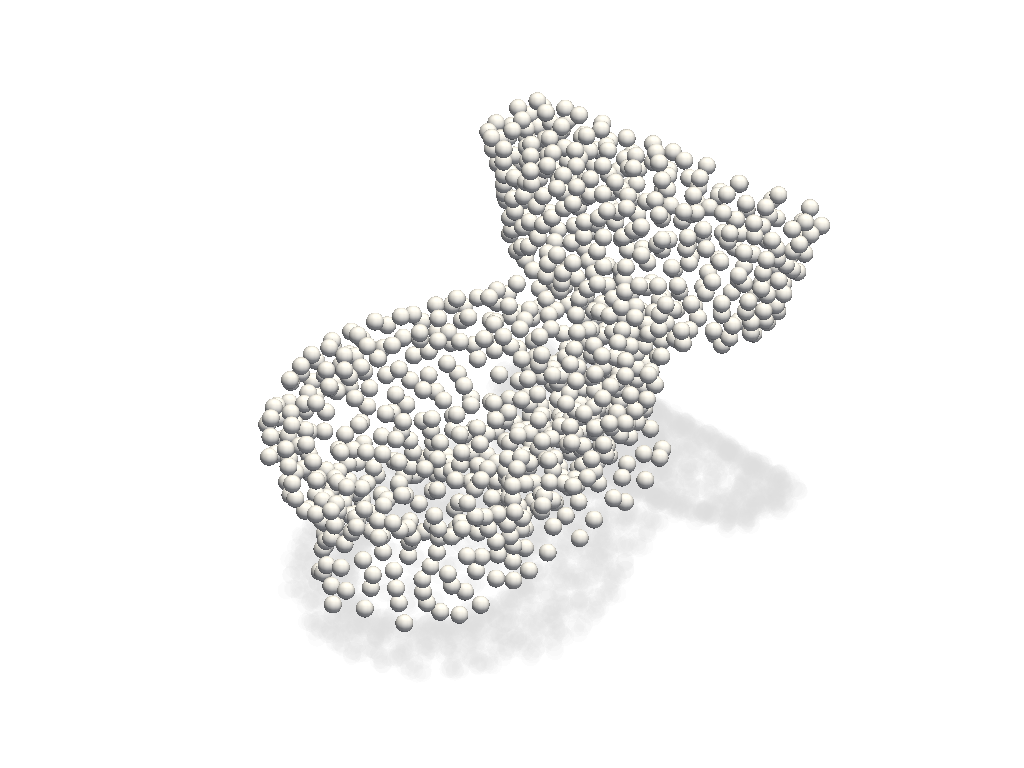

In [11]:
idx  = 0

point_size = 18


#         for camera_pos in angles:
plotter = pv.Plotter(notebook=True,shape=(1,1))
plotter.background_color = "W"


pos = origin_data[idx][:,[0,2,1]].cpu().numpy()
point_cloud = pv.PolyData(pos)
point_cloud['y'] = torch.zeros(args.num_points).numpy()
plotter.add_points(point_cloud, point_size=point_size, render_points_as_spheres=True, cmap=cmap)

get_shadow(plotter, pos, point_size,5)


plotter.camera_position = camera_pos
plotter.remove_scalar_bar()
light = pv.Light(intensity=0.15, shadow_attenuation = 0)
light.set_direction_angle(30,0)
plotter.add_light(light)
light = pv.Light(intensity=0.12, shadow_attenuation = 0)
light.set_direction_angle(30,180)
plotter.add_light(light)
#         plotter.screenshot('figs/{}/{}_compare.png'.format(class_choices[label[idx]], cnt[label[idx]]))

plotter.show()

0.1169593334197998
1010


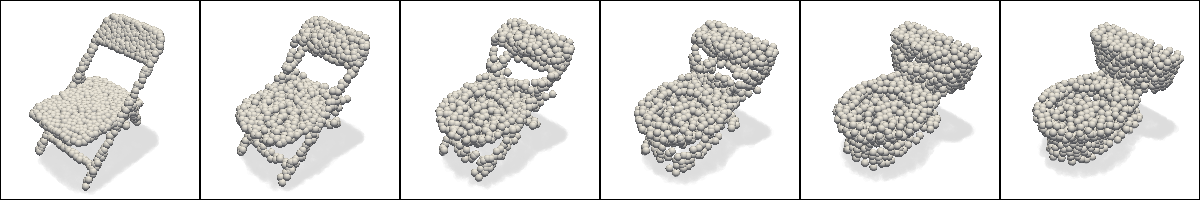

In [12]:
point_size = 8

plotter = pv.Plotter(notebook=True,shape=(1,6), window_size=(1200,200))

alpha= 0

B = args.batch_size
# idxs = torch.randperm(B)
# perm = data[idxs]

import time
a=time.time()
_, ass = EMD(origin_data, origin_perm, 0.005, 1000)
print(time.time() - a)
ass = ass.long()
origin_perm = origin_perm[:,ass][torch.arange(B),torch.arange(B)]

print(len(ass[1].unique()))


for i, alpha in enumerate(range(0,6)):
    alpha = alpha/5
    plotter.subplot(0,i)
    plotter.background_color = "W"
    
    new_data = alpha*origin_data + (1-alpha)*origin_perm
    pos = new_data[idx][:,[0,2,1]].cpu().numpy()

    point_cloud = pv.PolyData(pos)
    point_cloud['y'] = torch.zeros(args.num_points).numpy()
    plotter.add_points(point_cloud, point_size=point_size, render_points_as_spheres=True, cmap=cmap)

    get_shadow(plotter, pos, point_size,5)


    plotter.camera_position = camera_pos
    plotter.remove_scalar_bar()
#     light = pv.Light(intensity=0.15, shadow_attenuation = 0)
#     light.set_direction_angle(30,0)
#     plotter.add_light(light)
#     light = pv.Light(intensity=0.12, shadow_attenuation = 0)
#     light.set_direction_angle(30,180)
#     plotter.add_light(light)
    #         plotter.screenshot('figs/{}/{}_compare.png'.format(class_choices[label[idx]], cnt[label[idx]]))

plotter.show()

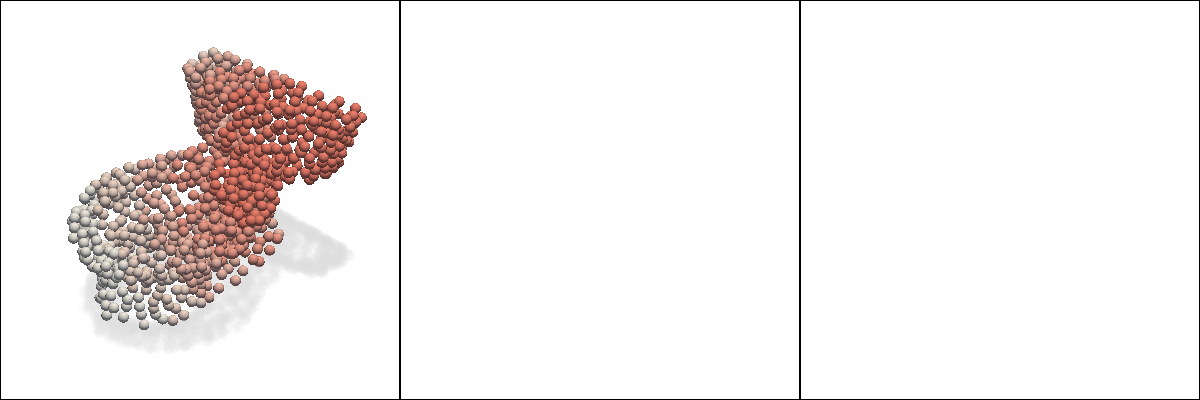

tensor([0.6289, 0.3711], device='cuda:0')


In [18]:
# idx  = 0
# sigma = 0.1
# sigma2 = 0.1

point_size = 11

plotter = pv.Plotter(notebook=True,shape=(1,3), window_size=(1200,400))

# anc_idx = torch.randperm(args.num_points)[:2]
# anchor_ori, anchor_perm = data[:,anc_idx[0],:], perm[:,anc_idx[1], :]
# # anchor_ori, anchor_perm = torch.tensor([0,-1,0])[None,:].repeat(16,1).cuda(), torch.tensor([0,1,0])[None,:].repeat(16,1).cuda()

# alpha = 0.5

# sub_ori = data - anchor_ori[:,None,:]
# sub_ori = ((sub_ori) ** 2).sum(2).sqrt()
# weight_ori = torch.exp(-0.5 * (sub_ori ** 2) / (sigma ** 2))  #(M,N)
# weight_ori = weight_ori * alpha

# sub_perm = perm - anchor_perm[:,None,:]
# sub_perm = ((sub_perm) ** 2).sum(2).sqrt()   
# weight_perm = torch.exp(-0.5 * (sub_perm ** 2) / (sigma2 ** 2))  #(M,N)
# weight_perm = weight_perm * (1-alpha)

# weight = (torch.cat([weight_ori[...,None],weight_perm[...,None]],-1))
# weight = weight/weight.sum(-1)[...,None]
# new_data = weight[:,:,0:1] * data + weight[:,:,1:] * perm

# # plotter = pv.Plotter(notebook=True,shape=(1,1))
plotter.subplot(0,0)
plotter.background_color = "W"

pos = origin_data[idx][:,[0,2,1]].cpu().numpy()
point_cloud = pv.PolyData(pos)
point_cloud['y'] = weight_ori[idx].cpu()
plotter.add_points(point_cloud, point_size=point_size, render_points_as_spheres=True, cmap=cmap)

get_shadow(plotter, pos, point_size,5)


plotter.camera_position = camera_pos
plotter.remove_scalar_bar()
# light = pv.Light(intensity=0.15, shadow_attenuation = 0)
# light.set_direction_angle(30,0)
# plotter.add_light(light)
# light = pv.Light(intensity=0.12, shadow_attenuation = 0)
# light.set_direction_angle(30,180)
# plotter.add_light(light)
#         plotter.screenshot('figs/{}/{}_compare.png'.format(class_choices[label[idx]], cnt[label[idx]]))

# plotter.show()

# plotter = pv.Plotter(notebook=True,shape=(1,1))
plotter.subplot(0,1)
plotter.background_color = "W"

pos = perm[idx][:,[0,2,1]].cpu().numpy()
point_cloud = pv.PolyData(pos)
point_cloud['y'] = weight_perm[idx].cpu()
plotter.add_points(point_cloud, point_size=point_size, render_points_as_spheres=True, cmap=cmap)

get_shadow(plotter, pos, point_size,5)


plotter.camera_position = camera_pos
plotter.remove_scalar_bar()
# light = pv.Light(intensity=0.15, shadow_attenuation = 0)
# light.set_direction_angle(30,0)
# plotter.add_light(light)
# light = pv.Light(intensity=0.12, shadow_attenuation = 0)
# light.set_direction_angle(30,180)
# plotter.add_light(light)
#         plotter.screenshot('figs/{}/{}_compare.png'.format(class_choices[label[idx]], cnt[label[idx]]))

# plotter.show()


# plotter = pv.Plotter(notebook=True,shape=(1,1))
plotter.subplot(0,2)
plotter.background_color = "W"


pos = data[idx][:,[0,2,1]].cpu().numpy()
point_cloud = pv.PolyData(pos)
point_cloud['y'] = torch.zeros(args.num_points).numpy()
plotter.add_points(point_cloud, point_size=point_size, render_points_as_spheres=True, cmap=cmap)

get_shadow(plotter, pos, point_size,5)


plotter.camera_position = camera_pos
plotter.remove_scalar_bar()
# light = pv.Light(intensity=0.15, shadow_attenuation = 0)
# light.set_direction_angle(30,0)
# plotter.add_light(light)
# light = pv.Light(intensity=0.12, shadow_attenuation = 0)
# light.set_direction_angle(30,180)
# plotter.add_light(light)
#         plotter.screenshot('figs/{}/{}_compare.png'.format(class_choices[label[idx]], cnt[label[idx]]))

plotter.show()

label = weight.sum(1)
label = label/label.sum(-1)[...,None]
print(label[idx])


In [14]:
w = weight.sum(1)

In [15]:
plotter = pv.Plotter(notebook=True,shape=(1,11), window_size=(2200,200))

point_size = 8

for i, alpha in enumerate(range(0,11)):
    alpha = alpha/10
    plotter.subplot(0,i)
    plotter.background_color = "W"
    
    sub_ori = data - anchor_ori[:,None,:]
    sub_ori = ((sub_ori) ** 2).sum(2).sqrt()
    weight_ori = torch.exp(-0.5 * (sub_ori ** 2) / (sigma ** 2))  #(M,N)
    weight_ori = weight_ori * alpha

    sub_perm = perm - anchor_perm[:,None,:]
    sub_perm = ((sub_perm) ** 2).sum(2).sqrt()   
    weight_perm = torch.exp(-0.5 * (sub_perm ** 2) / (sigma2 ** 2))  #(M,N)
    weight_perm = weight_perm * (1-alpha)

    weight = (torch.cat([weight_ori[...,None],weight_perm[...,None]],-1))
    weight = weight/weight.sum(-1)[...,None]
    new_data = weight[:,:,0:1] * data + weight[:,:,1:] * perm
    
    new_data = weight[:,:,0:1] * data + weight[:,:,1:] * perm
    pos = new_data[idx][:,[0,2,1]].cpu().numpy()

    point_cloud = pv.PolyData(pos)
    point_cloud['y'] = torch.zeros(args.num_points).numpy()
    plotter.add_points(point_cloud, point_size=point_size, render_points_as_spheres=True, cmap=cmap)

    get_shadow(plotter, pos, point_size,5)

    plotter.camera_position = camera_pos
    plotter.remove_scalar_bar()
    
    label = weight.sum(1)
    label = label/label.sum(-1)[...,None]
    print(label[idx])
    
#     print(weight[:,:,0:1][idx], weight[:,:,1:][idx])
    
plotter.show()

NameError: name 'sigma' is not defined

In [ ]:
import matplotlib.pyplot as plt
plt.hist(w.flatten().cpu().numpy(), bins=50)

In [ ]:
import matplotlib.pyplot as plt
plt.hist(w.flatten().cpu().numpy(), bins=50)